In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("../dataset/heart.csv")

In [6]:
# Initialize LabelEncoder.
label_encoder = LabelEncoder()

# Select columns with categorical data.
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply label encoding to each categorical column.
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

In [7]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

In [8]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [10]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)

ensemble_knn = BaggingClassifier(
    estimator=knn,
    n_estimators=10,         
    max_samples=0.8,  # sample 80% of training data for each base model.
    bootstrap=True,
    random_state=42
)

In [11]:
hetero_ensemble = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('ensemble_knn', ensemble_knn)
    ],
    voting='soft' 
)

In [12]:
hetero_ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=5,
                                                     random_state=42)),
                             ('ensemble_knn',
                              BaggingClassifier(estimator=KNeighborsClassifier(),
                                                max_samples=0.8,
                                                random_state=42))],
                 voting='soft')

In [13]:
y_pred = hetero_ensemble.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[68  9]
 [12 95]]
              precision    recall  f1-score   support

           0       0.85      0.88      0.87        77
           1       0.91      0.89      0.90       107

    accuracy                           0.89       184
   macro avg       0.88      0.89      0.88       184
weighted avg       0.89      0.89      0.89       184



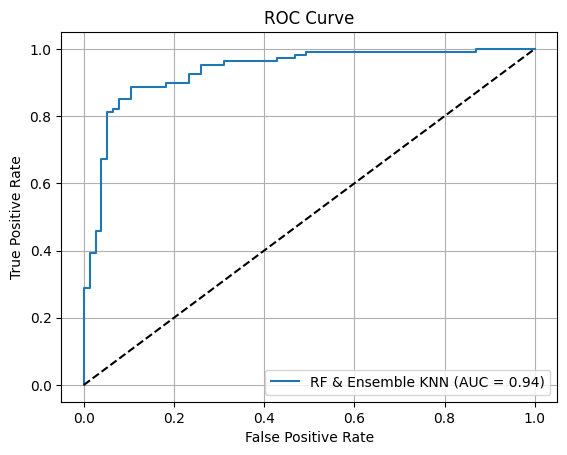

In [14]:
# Get predicted probabilities.
y_probs = hetero_ensemble.predict_proba(X_test)[:, 1]

# ROC curve.
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.plot(fpr, tpr, label=f'RF & Ensemble KNN (AUC = {roc_auc_score(y_test, y_probs):.2f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()